In [46]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import math

import datetime
import pandas as pd
import seaborn as sns
import tensorflow as tf

from opt_weights import *
from model_inputs import *
from constructions import *
from model import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


notes:
- autoencode - regularize
- model only has holes when Xs is missing data -build_Xs_from_returns(ret, 10) leads to big holes
- add function to combine different signals (momentum, value, prev returns) 
  - shold allow for returning 2d or 1d
- add convolution layer to build common up/dn forecast
- add check for holes in Xs
- incorporate vol and cash factors

issues:
- when input data is weak, model just loads proportionally on the most likely max ticker
- optimal weights don't always beat out equal weights, but they should
- with opt weights, understand why top ticker in a period is selected - does max weight ticker tend to have highest return in that period

In [79]:
import pandas.io.data as web
start_date = datetime.date(2005,1,1)
end_date = datetime.date(2012,5,1)
#tickers = ["^GSPC", "^DJI", "^IXIC", "^FCHI", "^FTSE", "^N225"]
tickers = ['GOOG', 'JPM', 'XOM', 'DIS', 'PFE', 'WMT']
px = web.DataReader(tickers, 'yahoo', start_date, end_date).Close
ret = px.div(px.shift()).dropna()
#ret = pd.read_csv('tests/test_data/returns.csv', parse_dates=['Date'], index_col=0)

In [80]:
# risk = .2
# scaler = risk / (ret.std() * math.sqrt(250.))
# ret = ((ret - 1.) * scaler).applymap(lambda x: x + 1.)

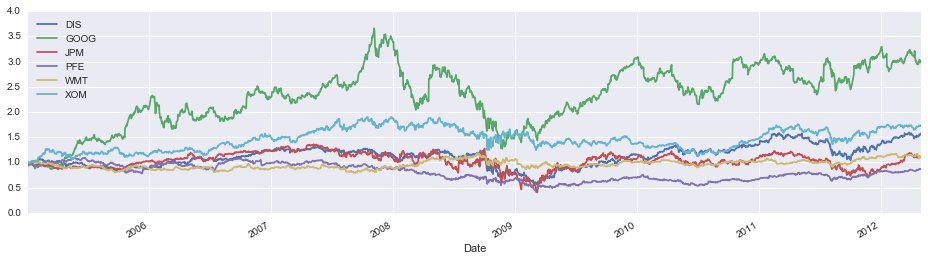

In [81]:
ret.cumprod().plot(figsize=[16,4])

find optimal target regression parameters

In [94]:
#grid = cum_prod_grid(ret, np.exp(np.linspace(-20, 1, 5)), look_ahead_pers=xrange(1,32,10))
grid[grid.norm_type==2].pivot(index='alpha', columns='look_ahead_per', values='cum_ret')

look_ahead_per,1,11,21,31
alpha,,,,
2.061154e-09,0.674006,1.125427,1.426147,1.443806
3.927864e-07,0.674937,1.125516,1.426318,1.443852
7.485183e-05,0.763935,1.158550,1.432994,1.451736
1.426423e-02,1.285213,1.540028,1.744606,1.786300
2.718282e+00,1.718230,1.719879,1.724736,1.727989


prep model inputs

In [95]:
opt_weights_func = lambda x: calc_opt_weights(x, alpha=1.426423e-02, norm_type=2)
opt_weights = rolling_fit_opt_weights(ret, opt_weights_func, 30)
ys = pd.DataFrame(opt_weights.values, index=opt_weights.index, columns=opt_weights.columns)

In [96]:
peak = get_peak_ahead_returns(ret, 20)
#hist_ret = build_Xs_from_returns(ret, 10)
cov = map_to_date(ret, '2007-1-1', get_flat_cov_matrix)
mom = xs_score(get_momentum(ret, 6*30))
val = xs_score(get_value(ret, 6*30))

In [97]:
Xs = pd.concat([peak, cov, mom, val], axis=1).dropna()

In [98]:
Xs.equals(ys)

False

In [99]:
print Xs.shape
print ys.shape
Xs, ys = validate_and_format_Xs_ys(Xs, ys)
print Xs.shape
print ys.shape
train, test = split_inputs_by_date(Xs, ys, datetime.date(2200,1,1), buffer_days=1)
Xs_train, ys_train = train[0].values, train[1].values 

(1323, 39)
(1815, 6)
(1313, 39)
(1313, 6)


In [100]:
# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
#Xs, ys = mnist.train.next_batch(1500)

n hidden layers with softmax

In [102]:
from model import *
probs, labels, stats = train_nn_softmax(Xs_train, ys_train, [20,], 2000, 500, .1)

step     0:	loss: 1.90	(0.21 sec)
step   100:	loss: 1.72	(0.51 sec)
step   200:	loss: 1.71	(0.82 sec)
step   300:	loss: 1.71	(1.11 sec)
step   400:	loss: 1.71	(1.43 sec)
step   500:	loss: 1.70	(1.78 sec)
step   600:	loss: 1.71	(2.12 sec)
step   700:	loss: 1.71	(2.48 sec)
step   800:	loss: 1.71	(2.82 sec)
step   900:	loss: 1.69	(3.11 sec)
step  1000:	loss: 1.70	(3.44 sec)
step  1100:	loss: 1.71	(3.77 sec)
step  1200:	loss: 1.69	(4.09 sec)
step  1300:	loss: 1.70	(4.38 sec)
step  1400:	loss: 1.70	(4.66 sec)
step  1500:	loss: 1.69	(5.09 sec)
step  1600:	loss: 1.70	(5.44 sec)
step  1700:	loss: 1.71	(5.77 sec)
step  1800:	loss: 1.69	(6.10 sec)
step  1900:	loss: 1.71	(6.43 sec)
accuracy:	0.697638988495
cross entropy:	1.69532811642


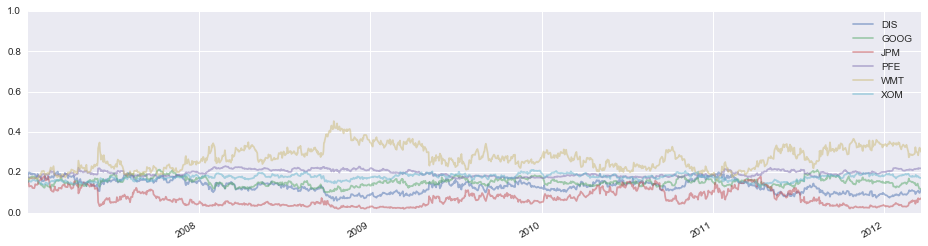

In [103]:
probs = pd.DataFrame(probs, columns=ys.columns, index=ys.index)
probs.plot(figsize=[16,4], ylim=[0,1], alpha=.5)

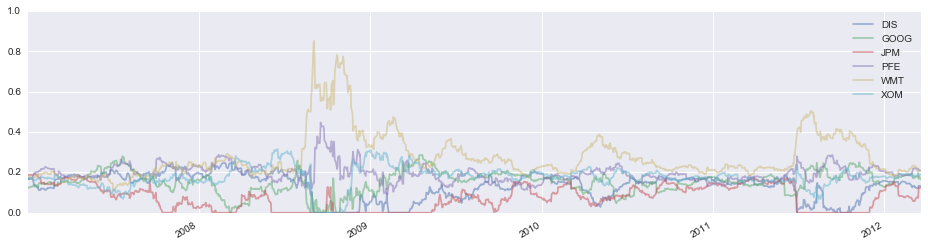

In [104]:
ys.plot(figsize=[16,4], ylim=[0,1], alpha=.5)

In [106]:
cols = list(ys.columns)
cols = dict(map(lambda x: (cols.index(x), x), cols))
labels = pd.Series(labels).map(lambda x: cols[x])
print('predicted max columns:')
print labels.value_counts()
print
print('actual max columns:')
print ys.apply(lambda x: list(x).index(max(x)), axis=1).map(lambda x: cols[x]).value_counts()

predicted max columns:
WMT     1235
DIS       37
PFE       23
GOOG      16
XOM        2
dtype: int64

actual max columns:
WMT     937
PFE     160
XOM      87
GOOG     84
DIS      36
JPM       9
dtype: int64


analytics

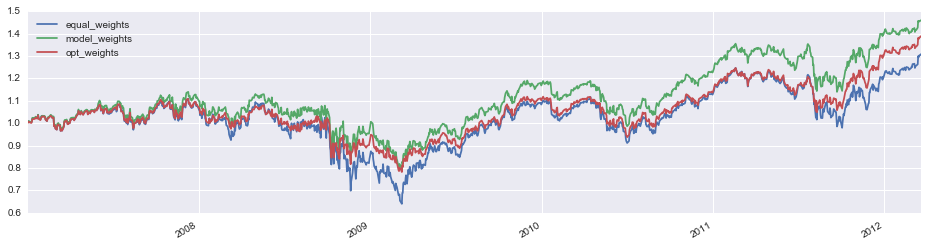

In [107]:
equal_weights = pd.Series({k: 1./ret.shape[1] for k in ret.columns})
perf = pd.DataFrame({'equal_weights': ret.mul(equal_weights).sum(axis=1),
                     'opt_weights': ret.mul(opt_weights).sum(axis=1),
                     'model_weights': ret.mul(probs).sum(axis=1)
                    })
perf.ix[Xs.index].cumprod().plot(figsize=[16,4])